In [1]:
import math, pylab, csv
import xarray as xr
import numpy as np
from datetime import datetime
from datetime import date
from itertools import groupby
from collections import Counter
from matplotlib.path import Path
import matplotlib.pyplot as plt
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
#%matplotlib widget
from scipy.ndimage import generic_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
import seaborn as sns 
import pandas

In [2]:
# %matplotlib widget

In [3]:
fontsize = 20

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

In [4]:
ds = xr.open_dataset('Edward_Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20240723.nc')
ds

<xarray.Dataset> Size: 202kB
Dimensions:                        (obs: 223, NbSample: 20)
Dimensions without coordinates: obs, NbSample
Data variables: (12/27)
    amplitude                      (obs) float64 2kB ...
    effective_area                 (obs) float32 892B ...
    effective_contour_height       (obs) float32 892B ...
    effective_contour_latitude     (obs, NbSample) float64 36kB ...
    effective_contour_longitude    (obs, NbSample) float64 36kB ...
    effective_contour_shape_error  (obs) float64 2kB ...
    ...                             ...
    speed_contour_longitude        (obs, NbSample) float64 36kB ...
    speed_contour_shape_error      (obs) float64 2kB ...
    speed_radius                   (obs) float64 2kB ...
    time                           (obs) datetime64[ns] 2kB ...
    track                          (obs) uint32 892B ...
    uavg_profile                   (obs, NbSample) float64 36kB ...
Attributes: (12/19)
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    creator_email:             aviso@altimetry.fr
    creator_url:               https://www.aviso.altimetry.fr
    date_created:              2024-08-06T09:38:06Z
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    ...                        ...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   This dataset contains eddy atlas from all-sate...
    time_coverage_duration:    P2396D
    time_coverage_end:         2024-07-23T00:00:00Z
    time_coverage_start:       2018-01-01T00:00:00Z
    title:                     Mesoscale Cyclonic Eddies in Altimeter Observa...

In [5]:
def in_eddy(ds,float_lat,float_lon,float_time):
    """
    float_lat: degrees north
    float_lon: degrees east
    float_time: should be in format 'YYYY-MM-DD'
    """

    def all_equal(iterable):
        g = groupby(iterable)
        return next(g, True) and not next(g, False)

    in_eddy_flag = False 

    float_time = np.datetime64(float_time)
    if float_time in ds.time: # some dates not in dateset        
        for i in np.where(ds.time == float_time)[0]: # usually will only be 1 eddy, but sometimes there are 2 after a split
            contour_lons = np.array(ds.effective_contour_longitude[i]) # eddy lons
            contour_lats = np.array(ds.effective_contour_latitude[i]) # eddy lats
            
            if all_equal(contour_lons): # eddy break
                pass
            else:
                poly = Path([(contour_lats[j],contour_lons[j]) for j in np.arange(0,len(contour_lats))]) # set up the polygon
                if poly.contains_points([(float_lat,float_lon)]): #find if point is inside the polygon
                    in_eddy_flag = True 

    return in_eddy_flag

In [6]:
in_eddy(ds,35,289.5,'2024-05-08')



True

In [7]:
# PACE CHL
results = earthaccess.search_datasets(instrument="oci")

tspan = ("2024-05-08", "2024-05-08")
#bbox = (-58, 37.5, -52, 41) #howie
bbox = (-73, 35, -70, 37) #edward
# bbox=(-61, 34, -59, 39) #patrick
clouds = (0, 100)
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

paths = earthaccess.open(results) #'streaming' data

datatree = open_datatree(paths[0])
datatree
dataset = xr.merge(datatree.to_dict().values())
dataset
dataset = dataset.set_coords(("longitude", "latitude"))

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

(-73.0, -68.0)

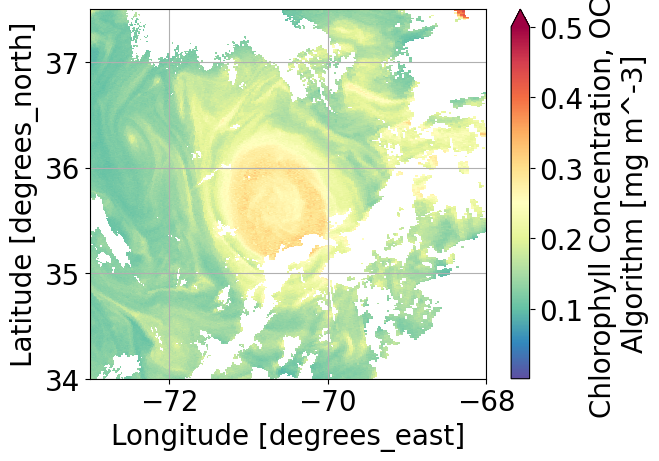

In [8]:
fig = plt.figure()
ax = plt.axes()#projection=ccrs.PlateCarree())
#ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot=dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="Spectral_r", vmax=0.5, ax=ax) #tried adding ,transform=ccrs.PlateCarree()
#plot=plt.pcolor(dataset["longitude"].values,dataset["latitude"].values,dataset["chlor_a"].values, cmap="Spectral_r", vmax=0.5,transform=ccrs.PlateCarree())
ax.grid(True)
ax.set_ylim([34,37.5])
ax.set_xlim([-73,-68])

In [9]:
# crop swot xarray
# Create a mask for the desired latitude range
bbox = (-73, 34, -68, 37.5) #edward
mask = (dataset.longitude >= bbox[0]) & (dataset.longitude <= bbox[2]) & (dataset.latitude >= bbox[1]) & (dataset.latitude <= bbox[3])
print(mask.sum())
# Check if the mask is valid (non-empty)
if mask.sum() == 0:
    mask = (dataset.longitude >= bbox[0]) & (dataset.longitude <= bbox[2])
    if mask.sum() == 0:
        print('Mask via longitude only')
        mask = (dataset.latitude >= bbox[1]) & (dataset.latitude <= bbox[3])
        print(mask.sum())
    else:
        print('Mask via latitude only')
        print(mask.sum())
# Apply the mask to slice the dataset
ds_masked = dataset.where(mask, drop=True)

<xarray.DataArray ()> Size: 8B
array(71564)


In [10]:
lat=ds_masked.latitude.values.flatten()
lon=ds_masked.longitude.values.flatten()+360
chl=ds_masked.chlor_a.values.flatten()

chl_inside,chl_outside=[],[]

for index in np.arange(0,len(lat)):
    val=in_eddy(ds,lat[index],lon[index],'2024-05-08')
    if val:
        chl_inside.append(chl[index])
        # chl_outside.append(np.nan)
    else:
        chl_outside.append(chl[index])
        # chl_inside.append(np.nan)

In [12]:
dataset = xr.open_dataset('moana_dataset_merged.nc')

In [13]:
np.nanmean(chl_inside)

0.24593332

In [14]:
# Create a mask for the desired latitude range
bbox = (-73, 34, -68, 37.5) #edward
mask = (dataset.longitude >= bbox[0]) & (dataset.longitude <= bbox[2]) & (dataset.latitude >= bbox[1]) & (dataset.latitude <= bbox[3])
print(mask.sum())
# Check if the mask is valid (non-empty)
if mask.sum() == 0:
    mask = (dataset.longitude >= bbox[0]) & (dataset.longitude <= bbox[2])
    if mask.sum() == 0:
        print('Mask via longitude only')
        mask = (dataset.latitude >= bbox[1]) & (dataset.latitude <= bbox[3])
        print(mask.sum())
    else:
        print('Mask via latitude only')
        print(mask.sum())
# Apply the mask to slice the dataset
ds_masked_moana = dataset.where(mask, drop=True)

<xarray.DataArray ()> Size: 8B
array(71564)


In [15]:
pico=ds_masked_moana["picoeuk_moana"].values.flatten()
lon = ds_masked_moana['longitude'].values.flatten()+360
lat = ds_masked_moana['latitude'].values.flatten()
pro = ds_masked_moana['prococcus_moana'].values.flatten()
pico = ds_masked_moana['picoeuk_moana'].values.flatten()
syn = ds_masked_moana['syncoccus_moana'].values.flatten()

In [16]:
pico_out,pico_in,pro_in,pro_out,syn_in,syn_out=[],[],[],[],[],[]

for index in np.arange(0,len(lat)):
    val=in_eddy(ds,lat[index],lon[index],'2024-05-08')
    if val:
        pico_in.append(pico[index])
        pro_in.append(pro[index])
        syn_in.append(syn[index])
    else:
        pico_out.append(pico[index])
        pro_out.append(pro[index])
        syn_out.append(syn[index])

In [17]:
np.nanmean(pico_in)

3910.8284

In [18]:
argo=pandas.read_csv('float_surf.csv')
argo

,TIME,LATITUDE,LONGITUDE,ID,MLD,SURF_TEMP,SURF_PSAL,SURF_CHLA,SURF_BBP,SURF_NPP,SURF_SPICE
0,4/4/24,40.753500,-63.066400,F4903273_102,68.0,9.687000,34.224998,1.038409,0.002721,32.318576,0.472714
1,4/4/24,40.753500,-63.066400,F4903273_102,68.0,9.687000,34.224998,2.480414,0.003883,141.143959,0.472714
2,4/15/24,40.036700,-64.519400,F4903273_103,12.0,8.135000,32.966999,2.480414,0.003883,141.143959,-0.776015
3,4/15/24,40.036700,-64.519400,F4903273_103,12.0,8.135000,32.966999,1.342333,0.003276,113.786147,-0.776015
4,4/25/24,39.539300,-66.138300,F4903273_104,11.9,11.368000,34.050999,1.342333,0.003276,113.786147,0.632496
...,...,...,...,...,...,...,...,...,...,...,...
539,6/19/24,33.401985,-70.987251,F4902590_75,20.9,24.373000,36.501999,NaN,NaN,NaN,5.700197
540,6/29/24,33.648960,-71.725128,F4902590_76,10.1,25.901999,36.586000,NaN,NaN,NaN,6.231510
541,7/10/24,33.678604,-72.388229,F4902590_77,11.2,27.011999,36.549999,NaN,NaN,NaN,6.555775
542,7/20/24,33.112515,-73.547974,F4902590_78,21.4,27.721001,36.612000,NaN,NaN,NaN,6.832016


In [19]:
lon=np.array(argo['LONGITUDE'])+360
lat=np.array(argo['LATITUDE'])
spice=np.array(argo['SURF_SPICE'])
mld=np.array(argo['MLD'])
chl_float=np.array(argo['SURF_CHLA'])
bbp_float=np.array(argo['SURF_BBP'])
npp_float=np.array(argo['SURF_NPP'])

In [20]:
spice_out,spice_in,mld_out,mld_in,chl_float_in,chl_float_out,bbp_float_in,bbp_float_out,npp_float_in,npp_float_out=[],[],[],[],[],[],[],[],[],[]

for index in np.arange(0,len(lat)):
    val=in_eddy(ds,lat[index],lon[index],'2024-05-08')
    if val:
        spice_in.append(spice[index])
        mld_in.append(mld[index])
        chl_float_in.append(chl_float[index])
        bbp_float_in.append(bbp_float[index])
        npp_float_in.append(npp_float[index])
    else:
        spice_out.append(spice[index])
        mld_out.append(mld[index])
        chl_float_out.append(chl_float[index])
        bbp_float_out.append(bbp_float[index])
        npp_float_out.append(npp_float[index])

In [21]:
chl_out = [i for i in chl_outside if not(np.isnan(i))]
chl_in = [i for i in chl_inside if not(np.isnan(i))]

pico_in = [i for i in pico_in if not(np.isnan(i))]
pico_out = [i for i in pico_out if not(np.isnan(i))]

pro_in = [i for i in pro_in if not(np.isnan(i))]
pro_out = [i for i in pro_out if not(np.isnan(i))]

spice_out = [i for i in spice_out if not(np.isnan(i))]
spice_in = [i for i in spice_in if not(np.isnan(i))]

mld_in = [i for i in mld_in if not(np.isnan(i))]
mld_out = [i for i in mld_out if not(np.isnan(i))]

chl_float_in = [i for i in chl_float_in if not(np.isnan(i))]
chl_float_out = [i for i in chl_float_out if not(np.isnan(i))]

bbp_float_in = [i for i in bbp_float_in if not(np.isnan(i))]
bbp_float_out = [i for i in bbp_float_out if not(np.isnan(i))]

npp_float_in = [i for i in npp_float_in if not(np.isnan(i))]
npp_float_out = [i for i in npp_float_out if not(np.isnan(i))]

In [22]:
np.nanmean(chl_float_out)

0.22955416076969695

In [23]:
# value=np.concatenate([chl_out,chl_in,pico_out,pico_in,pro_out,pro_in,syn_out,syn_in,spice_out,spice_in,mld_in,mld_out])

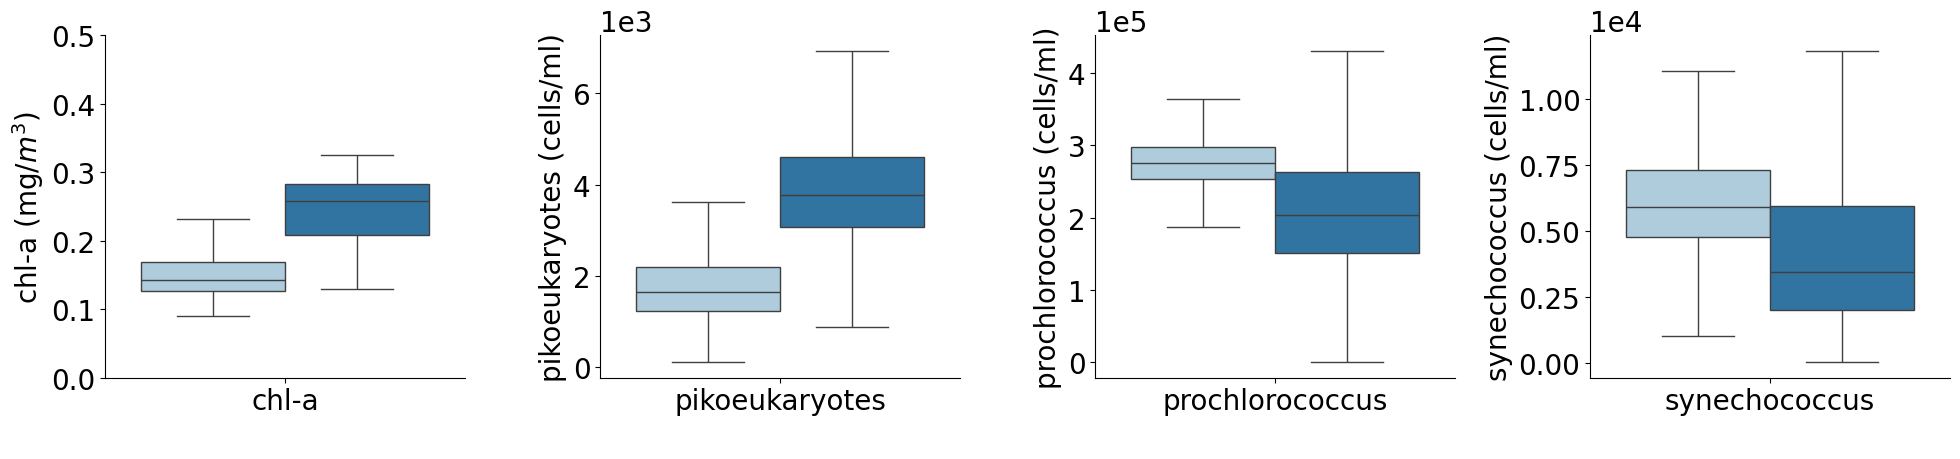

In [24]:
var=np.concatenate([np.repeat('chl-a',len(chl_out)),np.repeat('chl-a',len(chl_in))])
outin=np.concatenate([np.repeat('Outside',len(chl_out)),np.repeat('Inside',len(chl_in))]) 
value=np.concatenate([chl_out,chl_in])
d = {'var': var, 'outin': outin, 'value': value}
data = pandas.DataFrame(data=d)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

ax1=sns.boxplot(x = data['var'], 
            y = data['value'], 
            hue = data['outin'],showfliers=False, ax=ax1,palette="Paired")
ax1.set(ylim=[0,0.5])
ax1.set(xlabel=' ', ylabel='chl-a (mg/$m^{3}$)')
ax1.legend([],[], frameon=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

var=np.concatenate([np.repeat('pikoeukaryotes',len(pico_out)),np.repeat('pikoeukaryotes',len(pico_in))])
outin=np.concatenate([np.repeat('Outside',len(pico_out)),np.repeat('Inside',len(pico_in))]) 
value=np.concatenate([pico_out,pico_in])
d = {'var': var, 'outin': outin, 'value': value}
data = pandas.DataFrame(data=d)

ax2=sns.boxplot(x = data['var'], 
            y = data['value'], 
            hue = data['outin'],showfliers=False, ax=ax2,palette="Paired")
ax2.set(xlabel=' ', ylabel='pikoeukaryotes (cells/ml)')
ax2.legend([],[], frameon=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))


var=np.concatenate([np.repeat('prochlorococcus',len(pro_out)),np.repeat('prochlorococcus',len(pro_in))])
outin=np.concatenate([np.repeat('Outside',len(pro_out)),np.repeat('Inside',len(pro_in))]) 
value=np.concatenate([pro_out,pro_in])
d = {'var': var, 'outin': outin, 'value': value}
data = pandas.DataFrame(data=d)

ax3=sns.boxplot(x = data['var'], 
            y = data['value'], 
            hue = data['outin'],showfliers=False, ax=ax3,palette="Paired")
ax3.set(xlabel=' ', ylabel='prochlorococcus (cells/ml)')
ax3.legend([],[], frameon=False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))


var=np.concatenate([np.repeat('synechococcus',len(syn_out)),np.repeat('synechococcus',len(syn_in))])
outin=np.concatenate([np.repeat('Outside',len(syn_out)),np.repeat('Inside',len(syn_in))]) 
value=np.concatenate([syn_out,syn_in])
d = {'var': var, 'outin': outin, 'value': value}
data = pandas.DataFrame(data=d)

ax4=sns.boxplot(x = data['var'], 
            y = data['value'], 
            hue = data['outin'],showfliers=False, ax=ax4,palette="Paired")
ax4.set(xlabel=' ', ylabel='synechococcus (cells/ml)')
ax4.legend([],[], frameon=False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))




plt.tight_layout()

# sns.color_palette()


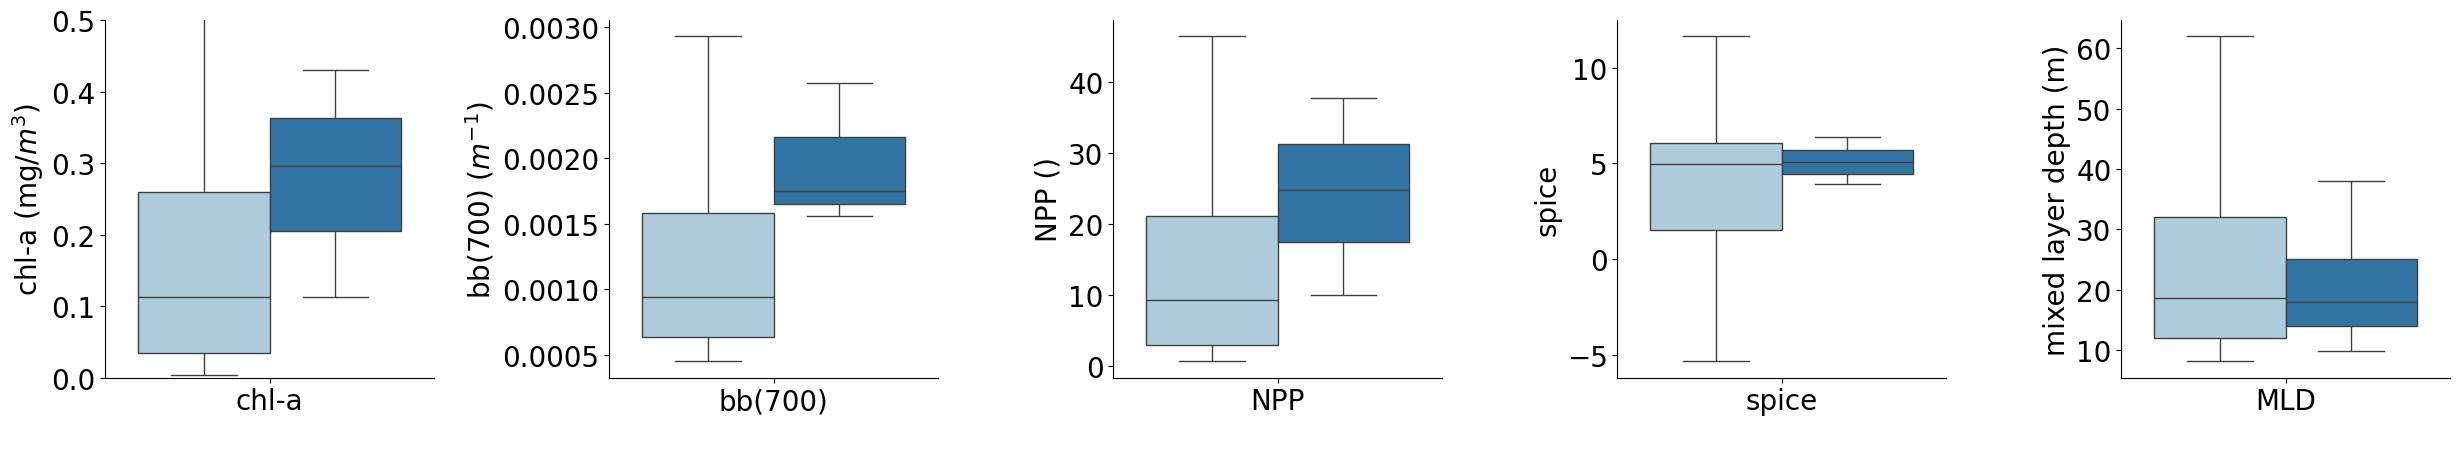

In [25]:
#argo floats - surface
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25,5))

var=np.concatenate([np.repeat('chl-a',len(chl_float_out)),np.repeat('chl-a',len(chl_float_in))])
outin=np.concatenate([np.repeat('Outside',len(chl_float_out)),np.repeat('Inside',len(chl_float_in))]) 
value=np.concatenate([chl_float_out,chl_float_in])
d = {'var': var, 'outin': outin, 'value': value}
data = pandas.DataFrame(data=d)

ax1=sns.boxplot(x = data['var'], 
            y = data['value'], 
            hue = data['outin'],showfliers=False, ax=ax1,palette="Paired")
ax1.set(xlabel=' ', ylabel='chl-a (mg/$m^{3}$)')
ax1.legend([],[], frameon=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set(ylim=[0,0.5])
plt.tight_layout()

var=np.concatenate([np.repeat('bb(700)',len(bbp_float_out)),np.repeat('bb(700)',len(bbp_float_in))])
outin=np.concatenate([np.repeat('Outside',len(bbp_float_out)),np.repeat('Inside',len(bbp_float_in))]) 
value=np.concatenate([bbp_float_out,bbp_float_in])
d = {'var': var, 'outin': outin, 'value': value}
data = pandas.DataFrame(data=d)

ax2=sns.boxplot(x = data['var'], 
            y = data['value'], 
            hue = data['outin'],showfliers=False, ax=ax2,palette="Paired")
ax2.set(xlabel=' ', ylabel='bb(700) ($m^{-1}$)')
ax2.legend([],[], frameon=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.tight_layout()

var=np.concatenate([np.repeat('NPP',len(npp_float_out)),np.repeat('NPP',len(npp_float_in))])
outin=np.concatenate([np.repeat('Outside',len(npp_float_out)),np.repeat('Inside',len(npp_float_in))]) 
value=np.concatenate([npp_float_out,npp_float_in])
d = {'var': var, 'outin': outin, 'value': value}
data = pandas.DataFrame(data=d)

ax3=sns.boxplot(x = data['var'], 
            y = data['value'], 
            hue = data['outin'],showfliers=False, ax=ax3,palette="Paired")
ax3.set(xlabel=' ', ylabel='NPP ()')
ax3.legend([],[], frameon=False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
plt.tight_layout()

var=np.concatenate([np.repeat('spice',len(spice_out)),np.repeat('spice',len(spice_in))])
outin=np.concatenate([np.repeat('Outside',len(spice_out)),np.repeat('Inside',len(spice_in))]) 
value=np.concatenate([spice_out,spice_in])
d = {'var': var, 'outin': outin, 'value': value}
data = pandas.DataFrame(data=d)

ax4=sns.boxplot(x = data['var'], 
            y = data['value'], 
            hue = data['outin'],showfliers=False, ax=ax4,palette="Paired")
ax4.set(xlabel=' ', ylabel='spice')
ax4.legend([],[], frameon=False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
plt.tight_layout()

var=np.concatenate([np.repeat('MLD',len(mld_out)),np.repeat('MLD',len(mld_in))])
outin=np.concatenate([np.repeat('Outside',len(mld_out)),np.repeat('Inside',len(mld_in))]) 
value=np.concatenate([mld_out,mld_in])
d = {'var': var, 'outin': outin, 'value': value}
data = pandas.DataFrame(data=d)

ax5=sns.boxplot(x = data['var'], 
            y = data['value'], 
            hue = data['outin'],showfliers=False, ax=ax5,palette="Paired")
ax5.set(xlabel=' ', ylabel='mixed layer depth (m)')
ax5.legend([],[], frameon=False)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
plt.tight_layout()